[CareerVillage](http://www.careervillage.org) is a question-and-answer website where underserved youth (usually high school and college students) can ask questions about college and careers, and have their questions answered by professionals in their field of interest.  It's like [StackOverflow](http://stackoverflow.com) for students with career-related questions!  The site is fantastic because it provides a platform for underserved students to get advice about careers and college, when they otherwise would not have access to guidance councelors, professionals, or any sort of network from which to ask these important questions.

Currently, Career Village recommends questions to professionals primarily based on what tags students have used to label their questions, and what tags each professional subscribes to.  In order to make professionals aware of the questions which best match their expertise, Career Village is looking to improve the way they recommend questions to professionals, and make better use of the data they have which goes beyond simple tags.

Here we'll develop an implicit content-based filtering system for recommending questions to professionals.  Given a question-professional pair, our model will predict how likely the professional is to answer the question.  This model can then be used to determine what new (or still-unanswered) questions a professional is most likely to answer, and those questions can be sent to the professional  either via email or via their landing page on the CareerVillage site.

The model will use not only tag similarity information, but will also extract information from the body of the question text, the question title, as well as information about the student which asked the question and the professional who may (hopfully) be able to answer it.  We'll be using [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup) and [nltk](https://www.nltk.org) for processing the text data, [bert-as-service](https://github.com/hanxiao/bert-as-service) to create sentence and paragraph embeddings using a pre-trained [BERT language model](https://github.com/google-research/bert), and [XGBoost](https://github.com/dmlc/xgboost) to generate predictions as to how likely professionals are to answer student questions.

TODO: outline

In [1]:
import subprocess
import re
import os

# SciPy stack
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA

# XGBoost
from xgboost import XGBClassifier

# NLP
import html as ihtml
from bs4 import BeautifulSoup
from nltk import tokenize
from scipy.sparse import coo_matrix

# Plot settings
%config InlineBackend.figure_format = 'svg'
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
# Target encoder and other utilities
!pip install git+http://github.com/brendanhasz/dsutils.git
from dsutils.encoding import TargetEncoderCV
from dsutils.evaluation import metric_cv
from dsutils.evaluation import permutation_importance_cv
from dsutils.evaluation import plot_permutation_importance

  Cloning http://github.com/brendanhasz/dsutils.git to /tmp/pip-req-build-jjuepv56
  Stored in directory: /tmp/pip-ephem-wheel-cache-7uv0yinu/wheels/a1/ff/2a/75bdc08e9c96d4917294db5e6faf99ef3de673f37992c52278
Successfully built dsutils
You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
# BERT-as-service
!pip install bert-serving-server
!pip install bert-serving-client

    100% |████████████████████████████████| 61kB 4.1MB/s 
    100% |████████████████████████████████| 1.1MB 22.0MB/s 
  Stored in directory: /tmp/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built GPUtil
  Found existing installation: pyzmq 17.0.0
    Uninstalling pyzmq-17.0.0:
      Successfully uninstalled pyzmq-17.0.0
You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Data Loading

TODO: list of tables, relationships between them, etc

go from

![Table Relationships](http://drive.google.com/uc?export=view&id=1qSBwFisuYIBBVg3LdIizoE5uLqiIiB2S)

to

![Prepared Matrix](http://drive.google.com/uc?export=view&id=1DKMSQybx3b3Rz87wt0A6a9sLKXLhtrfX)

etc

In [4]:
# Load all data
dfs = dict()
for file in os.listdir('../input'):
    dfs[file[:-4]] = pd.read_csv('../input/'+file, dtype=str)

# Convert integer cols to integer
int_cols = {
    'answer_scores': 'score',
    'question_scores': 'score',
}
for df, col in int_cols.items():
    dfs[df][col] = dfs[df][col].astype('int16')

# Convert date cols to datetime
datetime_cols = {
    'answers': 'answers_date_added',
    'comments': 'comments_date_added',
    'emails': 'emails_date_sent',
    'professionals': 'professionals_date_joined',
    'questions': 'questions_date_added',
    'students': 'students_date_joined',
}
for df, col in datetime_cols.items():
    dfs[df][col] = pd.to_datetime(dfs[df][col].str.slice(0, 19),
                                  format='%Y-%m-%d %H:%M:%S')

## Merge tags to questions, students, and professionals

Clean the tag text

In [5]:
def remove_hashtags(text):
    if type(text) is float:
        return ''
    else:
        return re.sub(r"#", "", text)
    
# Remove hashtag characters
dfs['tags']['tags_tag_name'] = \
    dfs['tags']['tags_tag_name'].apply(remove_hashtags)

A function which creates a list of tags for each user/question.

In [6]:
def agg_tags(df_short, df_long, short_col, long_col, long_col_agg):
    """Aggregate elements in a shorter df by joining w/ spaces"""
    grouped = df_long.groupby(long_col)
    joined_tags = grouped.agg({long_col_agg: lambda x: ' '.join(x)})
    out_df = pd.DataFrame(index=list(df_short[short_col]))
    out_df['aggs'] = joined_tags
    return list(out_df['aggs'])

Add a list of tags for each question to the questions table:

In [7]:
# Merge tags to questions
tag_questions = dfs['tag_questions'].merge(dfs['tags'],
                                           left_on='tag_questions_tag_id',
                                           right_on='tags_tag_id')
questions = dfs['questions']
questions['questions_tags'] = \
    agg_tags(questions, tag_questions,
             'questions_id', 'tag_questions_question_id', 'tags_tag_name')

Then add a list of tags to each professional / student.

In [8]:
# Merge tag text to tags
tag_users = dfs['tag_users'].merge(dfs['tags'], 
                                   left_on='tag_users_tag_id',
                                   right_on='tags_tag_id')

In [9]:
# Merge tags to students
students = dfs['students']
students['students_tags'] = \
    agg_tags(students, tag_users, 
             'students_id', 'tag_users_user_id', 'tags_tag_name')

In [10]:
# Merge tags to professionals
professionals = dfs['professionals']
professionals['professionals_tags'] = \
    agg_tags(professionals, tag_users, 
             'professionals_id', 'tag_users_user_id', 'tags_tag_name')

## BERT Embeddings of the Questions, Answers, and Comments

### Start the BERT server

In [11]:
# Download and unzip the model
!wget http://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
!unzip uncased_L-12_H-768_A-12.zip

--2019-05-02 01:08:21--  http://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 2607:f8b0:400e:c08::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M  71.3MB/s    in 5.5s    

2019-05-02 01:08:27 (71.3 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [12]:
# Start the BERT server
bert_command = 'bert-serving-start -model_dir /kaggle/working/uncased_L-12_H-768_A-12'
process = subprocess.Popen(bert_command.split(), stdout=subprocess.PIPE)

In [13]:
# Start the BERT client
from bert_serving.client import BertClient

In [14]:
bc = BertClient()

### Clean the sentences

Remove weird whitespace characters, HTML tags, etc w/ BeautifulSoup.

NOTE: we could pull out words after hashtags and add them to the tag list for this question, and then remove them from the question text, but for now will just remove the hashtag character and keep them in the Q text.

In [15]:
# Pull out a list of question/answer/comment text
questions_list = list(questions['questions_body'])
question_title_list = list(questions['questions_title'])
answers_list = list(dfs['answers']['answers_body'])
comments_list = list(dfs['comments']['comments_body'])

In [16]:
def clean_text(text):
    if type(text) is float:
        return ' '
    text = BeautifulSoup(ihtml.unescape(text), "html.parser").text
    text = re.sub(r"http[s]?://\S+", "", text)
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"#", "", text) #just remove hashtag character
    return text

In [17]:
questions_list = [clean_text(s) for s in questions_list]
question_title_list = [clean_text(s) for s in question_title_list]
answers_list = [clean_text(s) for s in answers_list]
comments_list = [clean_text(s) for s in comments_list]

/opt/conda/lib/python3.6/site-packages/bs4/__init__.py:282: UserWarning: "https://www.score.org/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/opt/conda/lib/python3.6/site-packages/bs4/__init__.py:282: UserWarning: "http://www.ncaa.org/about/resources/research/estimated-probability-competing-professional-athletics" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/opt/conda/lib/python3.6/site-packages/bs4/__init__.py:282: UserWarning: "http://www.organicauthority.com/so-you-want-to-be-a-farmer-consider-a-farm-apprenticeship/?utm_source=Organic+Authority+Newsletter&utm_campaign=2059ea4fb9-OA_Newsletter_

Now make each question, answer, and comment a list of sentences (instead of one continuous string).

In [18]:
questions_list = [tokenize.sent_tokenize(s) for s in questions_list]
answers_list = [tokenize.sent_tokenize(s) for s in answers_list]
comments_list = [tokenize.sent_tokenize(s) for s in comments_list]

### Embed the question title with BERT

In [19]:
%%time
question_title_embeddings = bc.encode(question_title_list)

/opt/conda/lib/python3.6/site-packages/bert_serving/client/__init__.py:286: UserWarning: some of your sentences have more tokens than "max_seq_len=25" set on the server, as consequence you may get less-accurate or truncated embeddings.
here is what you can do:
- disable the length-check by create a new "BertClient(check_length=False)" when you do not want to display this warning
- or, start a new server with a larger "max_seq_len"
  '- or, start a new server with a larger "max_seq_len"' % self.length_limit)


CPU times: user 28 ms, sys: 92 ms, total: 120 ms
Wall time: 18.9 s


### Compute average embedding of each sentence in Questions, Answers, and Comments

In [20]:
def bert_embed_paragraphs(paragraphs):
    """Embed paragraphs by taking the average embedding of each sentence
    
    Parameters
    ----------
    paragraphs : list of lists of str
        The paragraphs.  Each element should correspond to a paragraph
        and each paragraph should be a list of str, where each str is 
        a sentence.
    
    Returns
    -------
    embeddings : numpy ndarray of size (len(paragraphs), 768)
        The paragraph embeddings
    """
    
    # Covert to single list
    # (this is b/c bert-as-service is faster w/ one large request
    # than with many small requests)
    sentences = []
    ids = []
    for i in range(len(paragraphs)):
        sentences += paragraphs[i]
        ids += [i]*len(paragraphs[i])
        
    # Embed the sentences
    embeddings = bc.encode(sentences)
    
    # Average by paragraph id
    Np = len(paragraphs) #number of paragraphs
    n_dims = embeddings.shape[1]
    embeddings_out = np.full([Np, n_dims], np.nan)
    ids = np.array(ids)
    the_range = np.arange(len(ids))
    for i in range(n_dims):
        embeddings_out[:,i] = coo_matrix((embeddings[:,i], (ids, the_range))).mean(axis=1).ravel()
    return embeddings_out

In [21]:
%%time

# Embed questions
questions_embeddings = bert_embed_paragraphs(questions_list)
    
# Embed answers
answers_embeddings = bert_embed_paragraphs(answers_list)
    
# Embed comments
comments_embeddings = bert_embed_paragraphs(comments_list)

/opt/conda/lib/python3.6/site-packages/bert_serving/client/__init__.py:286: UserWarning: some of your sentences have more tokens than "max_seq_len=25" set on the server, as consequence you may get less-accurate or truncated embeddings.
here is what you can do:
- disable the length-check by create a new "BertClient(check_length=False)" when you do not want to display this warning
- or, start a new server with a larger "max_seq_len"
  '- or, start a new server with a larger "max_seq_len"' % self.length_limit)
/opt/conda/lib/python3.6/site-packages/bert_serving/client/__init__.py:286: UserWarning: some of your sentences have more tokens than "max_seq_len=25" set on the server, as consequence you may get less-accurate or truncated embeddings.
here is what you can do:
- disable the length-check by create a new "BertClient(check_length=False)" when you do not want to display this warning
- or, start a new server with a larger "max_seq_len"
  '- or, start a new server with a larger "max_seq_l

CPU times: user 16.6 s, sys: 2.1 s, total: 18.7 s
Wall time: 7min 16s


### Reduce dimensionality of the embeddings w/ PCA

In [22]:
%%time

pca = PCA(n_components=10)
question_title_embeddings = pca.fit_transform(question_title_embeddings)
questions_embeddings = pca.fit_transform(questions_embeddings)
answers_embeddings = pca.fit_transform(answers_embeddings)
comments_embeddings = pca.fit_transform(comments_embeddings)

CPU times: user 8.62 s, sys: 1.84 s, total: 10.5 s
Wall time: 5.98 s


### Add Embeddings to tables

In [23]:
# Drop the text data
questions.drop('questions_title', axis='columns', inplace=True)
questions.drop('questions_body', axis='columns', inplace=True)
answers = dfs['answers']
comments = dfs['comments']
answers.drop('answers_body', axis='columns', inplace=True)
comments.drop('comments_body', axis='columns', inplace=True)

In [24]:
def add_matrix_to_df(df, X, col_name):
    for iC in range(X.shape[1]):
        df[col_name+str(iC)] = X[:,iC]

In [25]:
# Add embeddings data
add_matrix_to_df(questions, questions_embeddings, 'questions_embeddings')
add_matrix_to_df(questions, question_title_embeddings, 'question_title_embeddings')
add_matrix_to_df(answers, answers_embeddings, 'answers_embeddings')
add_matrix_to_df(comments, comments_embeddings, 'comments_embeddings')

## Compute average embedding of questions each professional has answered

In [26]:
# Merge questions and answers
answer_questions = answers.merge(questions, 
                                 left_on='answers_question_id',
                                 right_on='questions_id')

# Merge answers and professionals
professionals_questions = answer_questions.merge(professionals, how='left',
                                                 left_on='answers_author_id',
                                                 right_on='professionals_id')

# Compute mean question embedding of all Qs each professional has answered
aggs = dict((c, 'mean') for c in professionals_questions if 'questions_embeddings' in c)
mean_prof_q_embeddings = (professionals_questions
                          .groupby('professionals_id')
                          .agg(aggs))
mean_prof_q_embeddings.columns = ['mean_'+x for x in mean_prof_q_embeddings.columns]
mean_prof_q_embeddings.reset_index(inplace=True)

# Add mean Qs embeddings to professionals table
professionals = professionals.merge(mean_prof_q_embeddings,
                                    how='left', on='professionals_id')

And do the same thing for the question titles:

In [27]:
# Compute mean question title embedding of all Qs each professional has answered
aggs = dict((c, 'mean') for c in professionals_questions if 'question_title_embeddings' in c)
mean_q_title_embeddings = (professionals_questions
                          .groupby('professionals_id')
                          .agg(aggs))
mean_q_title_embeddings.columns = ['mean_'+x for x in mean_q_title_embeddings.columns]
mean_q_title_embeddings.reset_index(inplace=True)

# Add mean Qs embeddings to professionals table
professionals = professionals.merge(mean_q_title_embeddings,
                                    how='left', on='professionals_id')

## Sample questions which each professional has not answered

To train a model which predicts whether a professional will answer a given question or not, we'll need to construct a dataset containing examples of question-professional pairs which exist (that is, questions the professional has answered) and question-professional pairs which do *not* exist (questions the professional has *not* answered).  We obviously already have pairs which do exist (in the `answers` table), but we need to sample pairs which do not exist in order to have negative samples on which to train our model.  Coming up with these negative pairs is called [negative sampling](https://arxiv.org/abs/1310.4546), and is often used in natural language processing (also see this great [video about it](https://www.coursera.org/lecture/nlp-sequence-models/negative-sampling-Iwx0e)).  Here we'll just create negative samples once, instead of once per training epoch.

In [28]:
def add_negative_samples(A, B, k=5):
    """Add pairs which do not exist to positive pairs.
    
    If `A` and `B` are two corresponding lists , this function
    returns a table with two copies of elements in `A`.
    For the first copy, corresponding elements in `B` are unchaged.
    However, for the second copy, elements in `B` are elements
    which exist in `B`, but the corresponding `A`-`B` pair
    does not exist in the original pairs.
    
    Parameters
    ----------
    A : list or ndarray or pandas Series
        Indexes
    B : list or ndarray or pandas Series
        Values
    k : int
        Number of negative samples per positive sample.
        Default=5
    
    Returns
    -------
    Ao : list
        Output indexes w/ both positive and negative samples.
    Bo : list
        Output indexes w/ both positive and negative samples.
    E : list
        Whether the corresponding `Ao`-`Bo` pair exists (1) or
        does not (0) in the original input data.
    """
    
    # Convert to lists
    if isinstance(A, (np.ndarray, pd.Series)):
        A = A.tolist()
    if isinstance(B, (np.ndarray, pd.Series)):
        B = B.tolist()
    
    # Construct a dict of pairs for each unique value in A
    df = pd.DataFrame()
    df['A'] = A
    df['B'] = B
    to_sets = lambda g: set(g.values.tolist())
    pairs = df.groupby('A')['B'].apply(to_sets).to_dict()
    
    # Randomize B
    uB = np.unique(B) # unique elements of B
    nB = np.random.choice(uB, k*len(A)).tolist() #(hopefully) negative samples
        
    # Ensure pairs do not exist
    for i in range(k*len(A)):
        while nB[i] in pairs[A[i%len(A)]]:
            nB[i] = np.random.choice(uB)
            # NOTE: this will run forever if there's an element 
            # in A which has pairs w/ *all* unique values of B...
            
    # Construct output lists
    Ao = A*(k+1)
    Bo = B+nB
    E = [1]*len(A) + [0]*(k*len(A))
    return Ao, Bo, E

Now we can create a table which contains professional-question pairs which exist, and the same number of pairs for each professional which do *not* exist:

In [29]:
# Find negative samples
author_id_samples, question_id_samples, samples_exist = \
    add_negative_samples(answers['answers_author_id'], 
                         answers['answers_question_id'])

# Create table containing both positive and negative samples
train_df = pd.DataFrame()
train_df['target'] = samples_exist
train_df['professionals_id'] = author_id_samples
train_df['questions_id'] = question_id_samples

Finally, for each answer-question pair, we can add information about the professional who authored it (or did not author it), the question which it answered, and the student who asked that question.

In [30]:
# Merge with professionals table
train_df = train_df.merge(professionals, how='left',
                          on='professionals_id')

# Merge with questions table
train_df = train_df.merge(questions, how='left',
                          on='questions_id')

# Merge with students table
train_df = train_df.merge(students, how='left',
                          left_on='questions_author_id',
                          right_on='students_id')

In [31]:
# Delete extra columns that won't be used for prediction
del train_df['professionals_id']
del train_df['questions_id']
del train_df['professionals_headline'] #though this could definitely be used...
del train_df['questions_author_id']
del train_df['students_id']

## Extract date and time features

In [32]:
# Extract date and time features
train_df['students_joined_year']      = train_df['students_date_joined'].dt.year
train_df['students_joined_month']     = train_df['students_date_joined'].dt.month
train_df['students_joined_dayofweek'] = train_df['students_date_joined'].dt.dayofweek
train_df['students_joined_dayofyear'] = train_df['students_date_joined'].dt.dayofyear
train_df['students_joined_hour']      = train_df['students_date_joined'].dt.hour

train_df['questions_added_year']      = train_df['questions_date_added'].dt.year
train_df['questions_added_month']     = train_df['questions_date_added'].dt.month
train_df['questions_added_dayofweek'] = train_df['questions_date_added'].dt.dayofweek
train_df['questions_added_dayofyear'] = train_df['questions_date_added'].dt.dayofyear
train_df['questions_added_hour']      = train_df['questions_date_added'].dt.hour

train_df['professionals_joined_year']      = train_df['professionals_date_joined'].dt.year
train_df['professionals_joined_month']     = train_df['professionals_date_joined'].dt.month
train_df['professionals_joined_dayofweek'] = train_df['professionals_date_joined'].dt.dayofweek
train_df['professionals_joined_dayofyear'] = train_df['professionals_date_joined'].dt.dayofyear
train_df['professionals_joined_hour']      = train_df['professionals_date_joined'].dt.hour

# Remove original datetime columns
del train_df['students_date_joined']
del train_df['questions_date_added']
del train_df['professionals_date_joined']

## Jaccard similarity between question and professional tags

In [33]:
def jaccard_similarity(set1, set2):
    """Compute Jaccard similarity between two sets"""
    set1 = set(set1)
    set2 = set(set2)
    union_len = len(set1.intersection(set2))
    return union_len / (len(set1) + len(set2) - union_len)

In [34]:
def jaccard_similarity_df(df, col1, col2, sep=' '):
    """Compute Jaccard similarity between lists of sets.
    
    Parameters
    ----------
    df : pandas DataFrame
        data
    col1 : str
        Column for set 1.  Each element should be a string, with space-separated elements
    col2 : str
        Column for set 2.
        
    Returns
    -------
    pandas Series
        Jaccard similarity for each row in df
    """
    list1 = list(df[col1])
    list2 = list(df[col2])
    scores = []
    for i in range(len(list1)):
        if type(list1[i]) is float or type(list2[i]) is float:
            scores.append(0.0)
        else:
            scores.append(jaccard_similarity(
                list1[i].split(sep), list2[i].split(sep)))
    return pd.Series(data=scores, index=df.index)

In [35]:
# Compute jaccard similarity between professional and question tags
train_df['question_professional_tag_jac_sim'] = \
    jaccard_similarity_df(train_df, 'questions_tags', 'professionals_tags')

# Compute jaccard similarity between professional and student tags
train_df['student_professional_tag_jac_sim'] = \
    jaccard_similarity_df(train_df, 'students_tags', 'professionals_tags')

# Remove tag columns
del train_df['questions_tags']
del train_df['professionals_tags']
del train_df['students_tags']

TODO: and now we can plot histograms comparing the jac sims between pairs which were answered and those which weren't

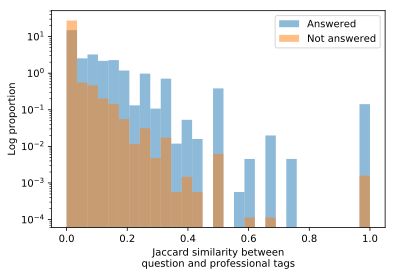

In [36]:
# Plot histograms of jac sim for Q-prof pairs
# which were answered and Q-prof pairs which weren't
bins = np.linspace(0, 1, 30)
answered = train_df['target']==1
plt.hist(train_df.loc[answered, 'question_professional_tag_jac_sim'],
         bins=bins, label='Answered', density=True,
         fc=matplotlib.colors.to_rgb(COLORS[0])+(0.5,))
plt.hist(train_df.loc[~answered, 'question_professional_tag_jac_sim'],
         bins=bins, label='Not answered', density=True,
         fc=matplotlib.colors.to_rgb(COLORS[1])+(0.5,))
plt.legend()
plt.yscale('log', nonposy='clip')
plt.xlabel('Jaccard similarity between\nquestion and professional tags')
plt.ylabel('Log proportion')
plt.show()

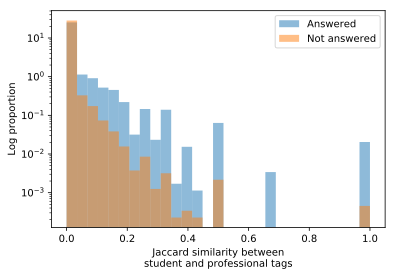

In [37]:
# Plot histograms of jac sim for Q-prof pairs
# which were answered and Q-prof pairs which weren't
bins = np.linspace(0, 1, 30)
answered = train_df['target']==1
plt.hist(train_df.loc[answered, 'student_professional_tag_jac_sim'],
         bins=bins, label='Answered', density=True,
         fc=matplotlib.colors.to_rgb(COLORS[0])+(0.5,))
plt.hist(train_df.loc[~answered, 'student_professional_tag_jac_sim'],
         bins=bins, label='Not answered', density=True,
         fc=matplotlib.colors.to_rgb(COLORS[1])+(0.5,))
plt.legend()
plt.yscale('log', nonposy='clip')
plt.xlabel('Jaccard similarity between\nstudent and professional tags')
plt.ylabel('Log proportion')
plt.show()

## Similarity between Question embeddings and average embedding for questions professionals have answered

In [38]:
def cosine_similarity_df(A, B):
    """Compute the cosine similarities between each row of two matrixes
    
    Parameters
    ----------
    A : numpy matrix or pandas DataFrame
        First matrix.
    B : numpy matrix or pandas DataFrame
        Second matrix.  Must be same size as A.
    
    Returns
    -------
    cos_sim : numpy ndarray of shape (A.shape[0],)
    """
    
    # Convert to numpy arrays
    if isinstance(A, pd.DataFrame):
        A = A.values
    if isinstance(B, pd.DataFrame):
        B = B.values
            
    # Ensure both matrixes are same size
    if not A.shape == B.shape:
        raise ValueError('A and B must be same size')
        
    # Compute dot products
    dot_prods = np.sum(A*B, axis=1)
    
    # Compute magnitudes
    mA = np.sqrt(np.sum(np.square(A), axis=1))
    mB = np.sqrt(np.sum(np.square(B), axis=1))
    
    # Return cosine similarity between rows
    return dot_prods / (mA*mB)

In [39]:
# Compute similarity between professional's mean Q embedding and Q embedding
mean_question_embedding_cols = [c for c in train_df.columns 
                                if 'mean_questions_embeddings' in c]
question_embedding_cols = [c for c in train_df.columns 
                           if 'questions_embeddings' in c and 'mean' not in c]
train_df['question_embedding_similarity'] = \
    cosine_similarity_df(train_df[mean_question_embedding_cols],
                         train_df[question_embedding_cols])

# Compute similarity between professional's mean Q embedding and Q title embedding
mean_title_embedding_cols = [c for c in train_df.columns 
                             if 'mean_question_title_embeddings' in c]
title_embedding_cols = [c for c in train_df.columns 
                        if 'question_title_embeddings' in c and 'mean' not in c]
train_df['title_embedding_similarity'] = \
    cosine_similarity_df(train_df[mean_title_embedding_cols],
                         train_df[title_embedding_cols])

Plotting the distributions of embedding similarities for questions which were vs questions which weren't answered:

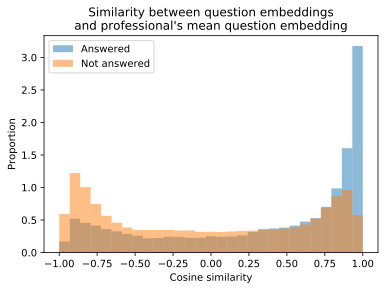

In [40]:
# Plot histograms of question embedding sim for Q-prof pairs
# which were answered and Q-prof pairs which weren't
bins = np.linspace(-1, 1, 30)
answered = train_df['target']==1
plt.hist(train_df.loc[answered, 'question_embedding_similarity'],
         bins=bins, label='Answered', density=True,
         fc=matplotlib.colors.to_rgb(COLORS[0])+(0.5,))
plt.hist(train_df.loc[~answered, 'question_embedding_similarity'],
         bins=bins, label='Not answered', density=True,
         fc=matplotlib.colors.to_rgb(COLORS[1])+(0.5,))
plt.legend()
plt.xlabel('Cosine similarity')
plt.ylabel('Proportion')
plt.title('Similarity between question embeddings\n'
          'and professional\'s mean question embedding')
plt.show()

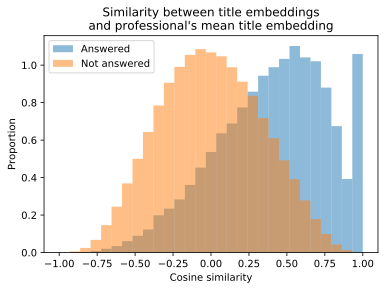

In [41]:
# Plot histograms of title embedding sim for Q-prof pairs
# which were answered and Q-prof pairs which weren't
bins = np.linspace(-1, 1, 30)
answered = train_df['target']==1
plt.hist(train_df.loc[answered, 'title_embedding_similarity'],
         bins=bins, label='Answered', density=True,
         fc=matplotlib.colors.to_rgb(COLORS[0])+(0.5,))
plt.hist(train_df.loc[~answered, 'title_embedding_similarity'],
         bins=bins, label='Not answered', density=True,
         fc=matplotlib.colors.to_rgb(COLORS[1])+(0.5,))
plt.legend()
plt.xlabel('Cosine similarity')
plt.ylabel('Proportion')
plt.title('Similarity between title embeddings\n'
          'and professional\'s mean title embedding')
plt.show()

Note that computing the mean embedding with *all* the data is introducing data leakage if we evaluate the model using cross validation.  For example, many of the cosine similarities are exactly 1.  This occurs when a professional has answered exactly one question (and so the similarity between the mean embedding of answered questions and the embedding of that questino are equal!).  With a cross-validated scheme, this couldn't occur because if a question-professional pair was in the test set, it wouldn't be in the training set, and we'd be forced to impute the embedding similarity (by, say, taking the mean similarity).

## Train model to predict probability of answering

In [42]:
train_df.columns.tolist()

['target',
 'professionals_location',
 'professionals_industry',
 'mean_questions_embeddings0',
 'mean_questions_embeddings1',
 'mean_questions_embeddings2',
 'mean_questions_embeddings3',
 'mean_questions_embeddings4',
 'mean_questions_embeddings5',
 'mean_questions_embeddings6',
 'mean_questions_embeddings7',
 'mean_questions_embeddings8',
 'mean_questions_embeddings9',
 'mean_question_title_embeddings0',
 'mean_question_title_embeddings1',
 'mean_question_title_embeddings2',
 'mean_question_title_embeddings3',
 'mean_question_title_embeddings4',
 'mean_question_title_embeddings5',
 'mean_question_title_embeddings6',
 'mean_question_title_embeddings7',
 'mean_question_title_embeddings8',
 'mean_question_title_embeddings9',
 'questions_embeddings0',
 'questions_embeddings1',
 'questions_embeddings2',
 'questions_embeddings3',
 'questions_embeddings4',
 'questions_embeddings5',
 'questions_embeddings6',
 'questions_embeddings7',
 'questions_embeddings8',
 'questions_embeddings9',
 'que

In [43]:
# Split into test and train
y_train = train_df['target']
X_train = train_df[[c for c in train_df if c is not 'target']]

In [44]:
# Categorical columns to target-encode
cat_cols = [
    'professionals_location',
    'professionals_industry',
    'students_location',
]

In [45]:
# Predictive model
model = Pipeline([
    ('target_encoder', TargetEncoderCV(cols=cat_cols)),
    ('scaler', RobustScaler()),
    ('imputer', SimpleImputer(strategy='median')),
    ('regressor', XGBClassifier())
])

In [46]:
%%time

# Compute cross-validated performance
metric_cv(model, X_train, y_train,
          metric=roc_auc_score,
          display='AUROC')

Cross-validated AUROC: 0.765 +/- 0.003
CPU times: user 21min 15s, sys: 5.27 s, total: 21min 20s
Wall time: 21min 21s


[0.7638571613246972, 0.7613412011571821, 0.7683889720797099]

Which features were the most important?  We can use permutation-based feature importance to see what features had the largest effect on the predictions.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


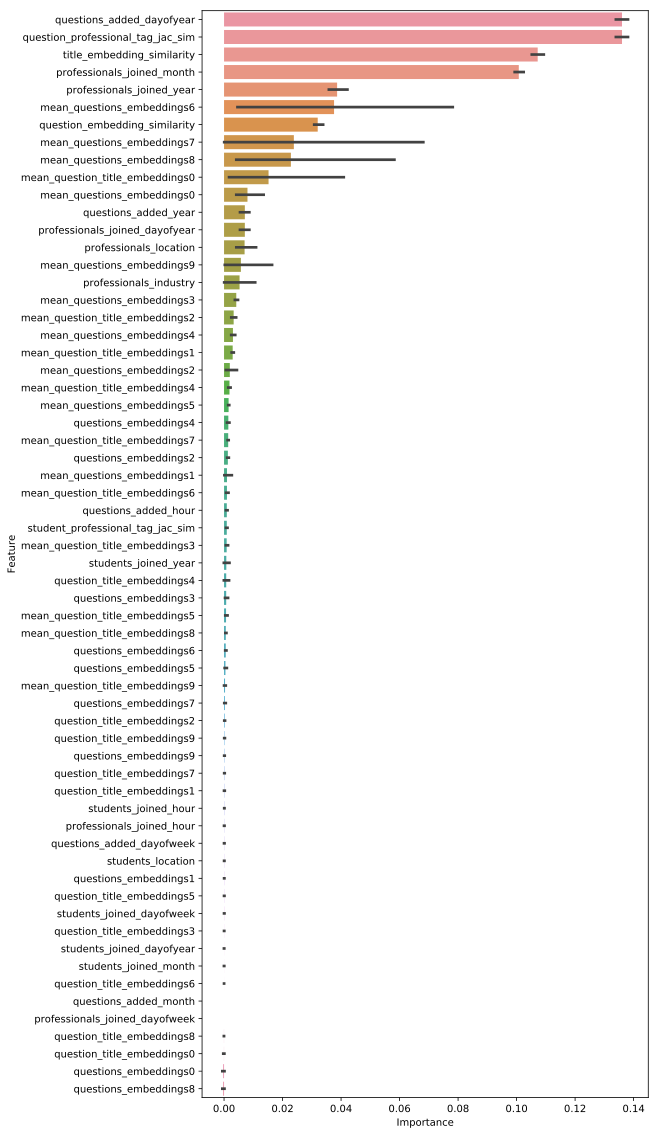

CPU times: user 2h 27min 34s, sys: 1min 51s, total: 2h 29min 26s
Wall time: 2h 26min 3s


In [47]:
%%time

# Compute the cross-validated feature importances
imp_df = permutation_importance_cv(
    X_train, y_train, model, 'auc')

# Plot the feature importances
plt.figure(figsize=(8, 20))
plot_permutation_importance(imp_df)
plt.show()

## Conclusion

TODO: what we did

How can this recommendation model be used to generate a list of questions to send to each professional?  Each week, we can generate a list of new questions asked this week (though the time interval doesn't have to be a week - it could be a day, or a month, etc).  This list could also potentially include older questions which have not yet been answered.  Then, for each professional, we can use the recommendation model to generate scores for each new question-professional pair (that is, the probabilities that the professional would answer a given question).  Finally, we could then send the questions with the top K scores (say, the top 10) to that professional.

Another strategy for using the recommendation model would be to recommend *professionals* for each question.  That is, given a question, come up with the top K professionals most likely to answer it, and reccomend the question to them.  This strategy could use the exact same method as described previously (generating a list of new questions, and pairing with each professional), except we would choose the *professionals* with the top K scores for a given question (as opposed to choosing the top K questions for a given professional).  There are pros and cons to this strategy relative to the previous one.  I worry that using this strategy would simply send all the questions to the professionals who answer the most questions (because their answer probabilities are likely to be higher), and not send any questions to professionals who answer fewer questions.  This could result in a small subset of overworked professionals, and the majority of professionals not receiving any recommended questions!  On the other hand, those professionals who answer the most questions are indeed more likely to answer the questions, so perhaps it's OK to send them a larger list of questions.  I think the optimal approach would be to use the first strategy (recommend K questions to each professional), but allow each professional to set their K - that is, let professionals choose how many questions they are recommended per week.

TODO: other data we had access to which we could include in a model: 
- scores/likes on the answers (predict which question professional will actually give *good* answers to)
- comments text (could also use to judge the usefullness of an answer)
- groups (might be an interaction between groups that students are in and groups profs are in)
- email data as mentioned before
- school memberships

The framework we created here uses a classifier to predict professional-question pairs - basically, a content-based filtering recommendation system.  However, there are other frameworks we could have used.  We could have framed the challenge as an implicit collaborative filtering problem (or even an explicit one if we attempted to predict the "hearts" given to professionals' answers).  I chose not to use a collaborative filtering framework because collaborative filtering suffers from the "cold-start" problem: it has trouble recommending users to new items.  This is because it depends on making predictions about user-item pair scores (in our case, whether professional-question pairs "exist" in the form of an answer) based on similarities between the query user and the scores of the query item by users similar to the query user.  Unfortunately, for this application it is especially important to recommend questions to professionals when the question has no answers yet!  So in production, more often than not there will *be* no scores of the query item by any other users when we want to be making the predictions.  Therefore, we have to use primarily the features about the users and the items to make recommendations.  Although some collaborative filtering methods can take into account the user and item features (such as neural collaborative filtering) I thought it would be best to use a framework which *only* uses the user and item features.

TODO: emails as "experiments"

TODO: recomend constant # qs to each professional each week vs optimially divyying up the Qs to professionals
